# DrEyeBot Retinal Image Analysis using CNN

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import datetime
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import imutils
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.utils.multiclass import unique_labels
from shutil import copyfile

import pandas as pd
import cv2
import seaborn as sn

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
from keras.models import Sequential,Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import model_from_json
from keras import applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.initializers import glorot_normal
from keras import losses

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop,SGD
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#from pyimagesearch.smallervggnet import SmallerVGGNet

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4821126654821430797
]


## Common Functions

### Helper Functions

In [83]:
def levelset(x):
    """ Sets Levels 1-4 to level 1"""
    if x>0:
        return 1
    else:
        return 0

def RMSE(actual, predict):
    diff = actual - predict
    diff = sum(diff**2) / len(actual)
    return np.sqrt(diff)

def select_toy_images(image_label,N=-1,images_percent=list()):
    """ Selects number of images from each class. By default it is ALL images"""
    image_list = list()
    final_images = pd.DataFrame(columns = image_label.columns)
    # We create a toy dataset of 'N' images, maintaining the split of the original 
    if N==-1:
            # We need to pick all the images. No need to sample
            # We can ignore the percentage here
            final_images = image_label
    else:
        for level in range(5):
        # Get respective number of images in each level
            if len(images_percent)==5:
                number_of_images = int(images_percent[level]*N/100)
            else:
                # We have no percentage of images. Setting the default safe percentage
                images_percent = [73.6,6.9,15.1,2.4,2]
                number_of_images = int(images_percent[level]*N/100)
            sample_images = image_label[image_label.level==level].sample(n=number_of_images,axis=0)
            frames = [final_images,sample_images]
            final_images = pd.concat(frames).reset_index(drop=True)
    return final_images 

def preprocess(image,scale=224):
    """ preprocess the test image and covert to array """
    inter=cv2.INTER_AREA
    (h, w) = image.shape[:2]
    dW = 0
    dH = 0

    width = scale
    height = scale
    
    # if the width is smaller than the height, then resize
    # along the width (i.e., the smaller dimension) and then
    # update the deltas to crop the height to the desired
    # dimension
    if w < h:
        image = imutils.resize(image, width=width,
            inter=inter)
        dH = int((image.shape[0] - height) / 2.0)

    # otherwise, the height is smaller than the width so
    # resize along the height and then update the deltas
    # crop along the width
    else:
        image = imutils.resize(image, height=height,
            inter=inter)
        dW = int((image.shape[1] - width) / 2.0)

    # now that our images have been resized, we need to
    # re-grab the width and height, followed by performing
    # the crop
    (h, w) = image.shape[:2]
    image = image[dH:h - dH, dW:w - dW]

    # finally, resize the image to the provided spatial
    # dimensions to ensure our output image is always a fixed
    # size

    image =  cv2.resize(image, (width, height),
        interpolation=inter)
    image_arr = img_to_array(image)
    image_arr = image_arr/255.0
    return img_to_array(image_arr)

def selector(x,threshold):
    """ Function to select the class"""
    if x[1] > threshold:
        return 1
    else:
        return 0

### Model related functions

In [6]:
def OrdinalLoss(y_true, y_pred):
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1))/(K.int_shape(y_pred)[1] - 1), dtype='float32')
    return (1.0 + weights) * losses.categorical_crossentropy(y_true, y_pred)

def OrdinalLoss_new(y_true,y_pred,train_out):
    """ Custom loss Function for Ordinal Data"""
    num_classes=5
    dx = np.ones((num_classes,1)) * np.arange(num_classes)
    dy = dx.transpose()
    d = np.sqrt(abs(dx - dy))
    overestimate_penalty = np.triu(d[:,1:]) / (np.spacing(1) + 
                                               (np.sum(np.triu(d[:,1:]), axis=1)/
                                                (np.arange(num_classes)[::-1]+np.spacing(1))).reshape((5,1)))
    underestimate_penalty = overestimate_penalty[::-1, ::-1]
    overestimate_penalty = tf.convert_to_tensor(overestimate_penalty, np.float32)
    underestimate_penalty = tf.convert_to_tensor(underestimate_penalty, np.float32)
    #loss_train = -K.mean(K.sum((underestimate_penalty[y_pred])*K.log(train_out) + (overestimate_penalty[y_pred])*K.log(1-train_out), axis=1))
    loss_train = K.binary_crossentropy(y_true, y_pred)
    loss_val = K.binary_crossentropy(y_true, y_pred)
    return K.in_train_phase(loss_train, loss_val)

def LossWrapper(train_out):
    def customLoss(y_true, y_pred):
        return OrdinalDataLoss_new(y_true, y_pred, train_out)
    return customLoss

In [7]:
def InceptionResNetV2(input_shape,layers_to_skip=None,weights=None,include_top=True):
    """ InceptionResNet with transfer learning. Using Keras built in function"""
    model = applications.inception_resnet_v2.InceptionResNetV2(weights = weights, include_top=include_top, input_shape = input_shape)
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    #model.compile(loss=OrdinalLoss,optimizer = sgd, metrics = ['accuracy'])
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final


def Resnetv1(input_shape,depth=50,layers_to_skip=None,weights=None,include_top=True):
    """ Resnet50 with transfer learning. Using Keras built in function"""
    
    if depth==50:
        model = applications.resnet50.ResNet50(weights = weights, include_top=include_top, input_shape = input_shape)
    elif depth == 101:
        model = applications.resnet101.ResNet101(weights = weights, include_top=include_top, input_shape = input_shape)
    else:
        model = applications.resnet152.ResNet152(weights = weights, include_top=include_top, input_shape = input_shape)
        
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    #model.compile(loss=OrdinalLoss,optimizer = sgd, metrics = ['accuracy'])
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final

def VGG_TL(input_shape,depth=16,layers_to_skip=None,weights=None,include_top=True):
    """ VGG with Transfer Learning. Using Keras built in function"""
    if depth==19:
        model = applications.VGG19(weights = weights, include_top=include_top, input_shape = input_shape)        
    else:
        model = applications.VGG16(weights = weights, include_top=include_top, input_shape = input_shape)
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    #model.compile(loss=OrdinalLoss,optimizer = sgd, metrics = ['accuracy'])
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final

def VGG_16(weights_path=None):
    initializer = glorot_normal()
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),input_shape=(length,width,depth),
                     activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu',kernel_initializer=initializer))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu',kernel_initializer=initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    #x = model.output
    #custom_loss = LossWrapper(train_out=x)
    # compile model
    model.compile(loss=OrdinalLoss,optimizer = sgd, metrics = ['accuracy'])
    #model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    #print(model.summary())
    return model

def CNN_FF():
    """ CNN with Feed Forward NN """
    model_conv = Sequential()
    model_conv.add(Conv2D(32, kernel_size=(5, 5), 
                                          input_shape=(length,width,depth),activation='relu'))
    model_conv.add(MaxPooling2D(pool_size=(2, 2)))
    model_conv.add(Conv2D(64, (5, 5), activation='relu'))
    model_conv.add(MaxPooling2D(pool_size=(2, 2)))
    model_conv.add(Flatten())
    model_conv.add(Dense(100))
    model_conv.add(Dropout(0.1))
    model_conv.add(Dense(num_classes, activation='softmax'))
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    model_conv.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    #print(model_conv.summary())
    return model_conv


def save_model(model,vgg=True):
    # saving model
    json_model = model.to_json()
    # Get today's date. We will use this as string for filename
    now = datetime.datetime.now()
    day = str(now)[:10]
    if vgg:
        arch_name = 'model_architecture_vgg_'+day+'35K_aug'+'.json'
        model_weights = 'model_weights_vgg_'+day+'35K_aug'+'.h5'
    else:
        arch_name = 'model_architecture_s_cnn'+day+'.json'
        model_weights = 'model_weights_s_cnn'+day+'.h5'
        
    open(arch_name, 'w').write(json_model)
    # saving weights
    model.save_weights(model_weights, overwrite=True)

def load_model(model_arch,model_weights):
    # loading model
    model = model_from_json(open(model_arch).read())
    model.load_weights(model_weights)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

## LOAD DATA

In [8]:
# Load the csv data
orig_label = pd.read_csv("./Retinal-Images/trainLabels.csv")
# Load the test csv data
test_label = pd.read_csv("./Retinal-Images/retinopathy_solution.csv")
test_label.drop('Usage',inplace=True,axis=1)

In [9]:
orig_label.count()

image    35126
level    35126
dtype: int64

In [10]:
test_label.count()

image    53576
level    53576
dtype: int64

In [11]:
orig_label.groupby(['level']).count()

,image
level,
0,25810
1,2443
2,5292
3,873
4,708


In [12]:
test_label.groupby(['level']).count()

,image
level,
0,39533
1,3762
2,7861
3,1214
4,1206


### DATA PREPERATION (SKIP THIS SECTION IF YOU ALREADY HAVE THE IMAGES IN RIGHT LOCATION)

In [13]:
l4_orig_df = orig_label[orig_label.level==4].sample(200,random_state=42)
l3_orig_df = orig_label[orig_label.level==3].sample(500,random_state=42)
l2_orig_df = orig_label[orig_label.level==2].sample(500,random_state=42)
l1_orig_df = orig_label[orig_label.level==1].sample(500,random_state=42)
l0_orig_df = orig_label[orig_label.level==0].sample(3300,random_state=42)
rest_orig_df = pd.concat([orig_label, l4_orig_df,l3_orig_df,
                          l2_orig_df,l1_orig_df,l0_orig_df]).drop_duplicates(keep=False)
len(rest_orig_df)

30126

In [14]:
l4_test_df = test_label[test_label.level==4].sample(200,random_state=42)
l3_test_df = test_label[test_label.level==3].sample(500,random_state=42)
l2_test_df = test_label[test_label.level==2].sample(500,random_state=42)
l1_test_df = test_label[test_label.level==1].sample(500,random_state=42)
l0_test_df = test_label[test_label.level==0].sample(3300,random_state=42)
rest_test_df = pd.concat([test_label, l4_test_df,l3_test_df,
                          l2_test_df,l1_test_df,l0_test_df]).drop_duplicates(keep=False)
len(rest_test_df)

48576

### Save the dataframes so that same sets can be loaded at a later point

In [15]:
l4_orig_df.to_pickle("./l4_orig_df.pkl")
l3_orig_df.to_pickle("./l3_orig_df.pkl")
l2_orig_df.to_pickle("./l2_orig_df.pkl")
l2_orig_df.to_pickle("./l1_orig_df.pkl")
l0_orig_df.to_pickle("./l0_orig_df.pkl")
rest_orig_df.to_pickle("./rest_orig_df.pkl")

l4_test_df.to_pickle("./l4_test_df.pkl")
l3_test_df.to_pickle("./l3_test_df.pkl")
l2_test_df.to_pickle("./l2_test_df.pkl")
l2_test_df.to_pickle("./l1_test_df.pkl")
l0_test_df.to_pickle("./l0_test_df.pkl")
rest_test_df.to_pickle("./rest_test_df.pkl")

In [16]:
val_list = [l0_orig_df,l1_orig_df,l2_orig_df,l3_orig_df,l4_orig_df]
test_list = [l0_test_df,l1_test_df,l2_test_df,l3_test_df,l4_test_df]
train_list = [rest_orig_df,rest_test_df]

In [17]:
test_labels=list()
test_labels.append(list(l0_test_df.level.values))
test_labels.append(list(l1_test_df.level.values))
test_labels.append(list(l2_test_df.level.values))
test_labels.append(list(l3_test_df.level.values))
test_labels.append(list(l4_test_df.level.values))
test_labels = [item for sublist in test_labels for item in sublist]
test_labels=np.asarray(test_labels)
test_labels.shape

(5000,)

In [18]:
test_image_list=list()
test_image_list.append(list(l0_test_df.image.values))
test_image_list.append(list(l1_test_df.image.values))
test_image_list.append(list(l2_test_df.image.values))
test_image_list.append(list(l3_test_df.image.values))
test_image_list.append(list(l4_test_df.image.values))
test_image_list = [item for sublist in test_image_list for item in sublist]
test_image_list=np.asarray(test_image_list)
test_image_list.shape

(5000,)

In [19]:
val_labels=list()
val_labels.append(list(l0_orig_df.level.values))
val_labels.append(list(l1_orig_df.level.values))
val_labels.append(list(l2_orig_df.level.values))
val_labels.append(list(l3_orig_df.level.values))
val_labels.append(list(l4_orig_df.level.values))
val_labels = [item for sublist in val_labels for item in sublist]
val_labels=np.asarray(val_labels)
val_labels.shape

(5000,)

In [20]:
val_image_list=list()
val_image_list.append(list(l0_orig_df.image.values))
val_image_list.append(list(l1_orig_df.image.values))
val_image_list.append(list(l2_orig_df.image.values))
val_image_list.append(list(l3_orig_df.image.values))
val_image_list.append(list(l4_orig_df.image.values))
val_image_list = [item for sublist in val_image_list for item in sublist]
val_image_list=np.asarray(val_image_list)
val_image_list.shape

(5000,)

In [21]:
test_image_list

array(['5458_left', '709_left', '7231_left', ..., '27843_left',
       '21621_right', '12369_right'], dtype='<U11')

In [22]:
test_labels

array([0, 0, 0, ..., 4, 4, 4])

In [23]:
true_test_labels = np.copy(test_labels)
true_val_labels = np.copy(val_labels)
test_labels[test_labels>0]=1
val_labels[val_labels>0]=1
test_labels

array([0, 0, 0, ..., 1, 1, 1])

In [24]:
true_test_labels

array([0, 0, 0, ..., 4, 4, 4])

## Load the best model : VGG-16 with first 7 layer weights from imagenet

In [25]:
testList = list(test_image_list)
valList = list(val_image_list)

In [50]:
def calc_proba_list(model,imageList,val=0,scale=224):
    image_class_proba_list = []
    for image in imageList:
        if val==1:
            image_loc = './Retinal-Images/train_resize_512_new/' + image + '.png'
        else:
            image_loc = './Retinal-Images/test_resize_512_new/' + image + '.png'
        image_test = cv2.imread(image_loc)
        image_test_mod = preprocess(image_test,scale=scale)
        image_test_pp_mod = np.expand_dims(image_test_mod,0)
        image_class_proba = model.predict(image_test_pp_mod).flatten()
        image_class_proba_list.append(image_class_proba)
    return image_class_proba_list

def get_pred_df(image_class_proba_list):
    """ Returns predicted class dataframe"""
    image_class_proba_arr = np.vstack(image_class_proba_list)
    image_class_arr = np.argmax(image_class_proba_arr,axis=1)
    df_pred_class = pd.DataFrame(test_image_list,columns=['Image'])
    df_pred_class['Actual'] = test_labels
    df_pred_class['Pred'] = image_class_arr
    df_pred_class['True_Label'] = true_test_labels
    df_pred_class['DR_Positive_Proba'] = image_class_proba_arr[:,1]
    
    return df_pred_class

In [27]:
model_vgg = load_model('./best_model_vgg16_20E_finalEpoch_l7_newOS.json',
                           './best_model_vgg16_20E_finalEpoch_l7_newOS.h5')

In [33]:
image_class_proba_list = calc_proba_list(model_vgg,testList,scale=224)
df_pred_class = get_pred_df(image_class_proba_list)
df_class_tp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_tn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_fp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual!=df_pred_class.Pred)]
df_class_fn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual!=df_pred_class.Pred)]

TN: 2272,FP: 1028, FN: 543, TP:1157


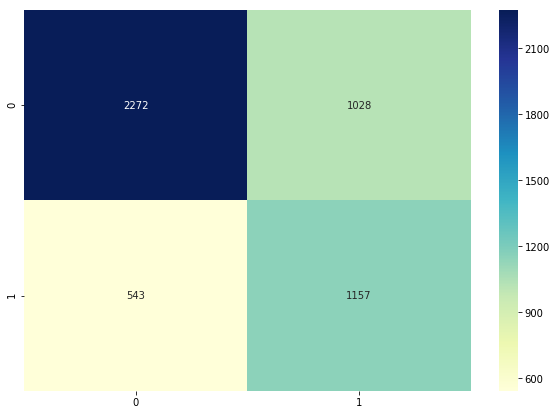

In [34]:
image_class_proba_arr = np.vstack(image_class_proba_list)
image_class_arr = np.argmax(image_class_proba_arr,axis=1)

cnf = confusion_matrix(test_labels, image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

### Load the best 512 model

In [35]:
# Best model returned instead of final epoch
model_vgg = load_model('./best_model_TL_l7_512_bg.json',
                           './best_model_TL_finalEpoch_l7_512_bg.h5')

In [36]:
image_class_proba_list = calc_proba_list(model_vgg,testList,scale=512)
df_pred_class = get_pred_df(image_class_proba_list)
df_class_tp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_tn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_fp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual!=df_pred_class.Pred)]
df_class_fn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual!=df_pred_class.Pred)]

TN: 2957,FP: 343, FN: 580, TP:1120


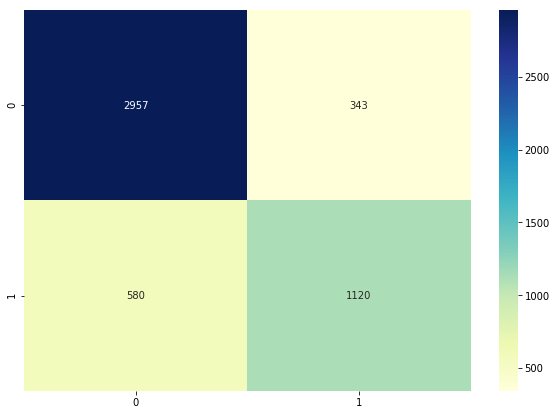

In [37]:
image_class_proba_arr = np.vstack(image_class_proba_list)
image_class_arr = np.argmax(image_class_proba_arr,axis=1)

cnf = confusion_matrix(test_labels, image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

### With images loaded from png (GraphicsMagick converted)

In [51]:
image_class_proba_list = calc_proba_list(model_vgg,testList,scale=512)
df_pred_class = get_pred_df(image_class_proba_list)
df_class_tp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_tn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_fp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual!=df_pred_class.Pred)]
df_class_fn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual!=df_pred_class.Pred)]

TN: 2900,FP: 400, FN: 537, TP:1163


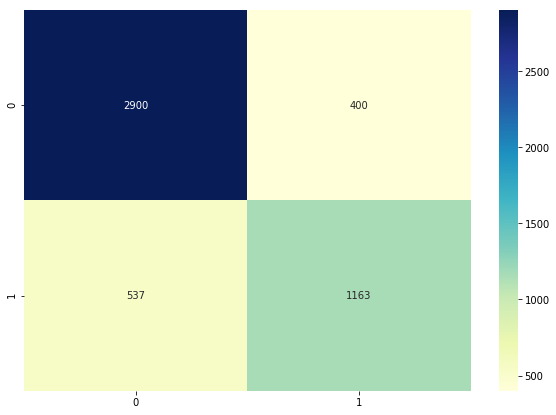

In [52]:
image_class_proba_arr = np.vstack(image_class_proba_list)
image_class_arr = np.argmax(image_class_proba_arr,axis=1)

cnf = confusion_matrix(test_labels, image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

In [88]:
#Fine tune the threshold
threshold=0.3
proba_df = pd.DataFrame(image_class_proba_arr,columns=['class_0','class_1'])
proba_df['winner'] = proba_df.apply(lambda x: selector(x, threshold),axis=1)

TN: 2570,FP: 730, FN: 395, TP:1305


/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


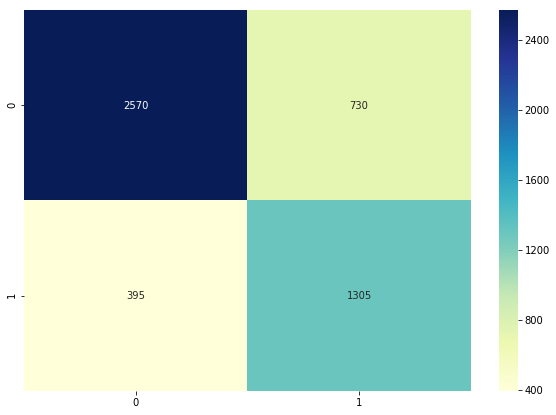

In [89]:
mod_image_class_arr = proba_df.winner.as_matrix(columns=None)
cnf = confusion_matrix(test_labels, mod_image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

## Inspect where we did good, and where we did bad

In [53]:
# Inspect false negatives
df_class_fn.head(5)

,Image,Actual,Pred,True_Label,DR_Positive_Proba
3300,18565_right,1,0,1,0.084235
3301,35123_left,1,0,1,0.399371
3302,2592_left,1,0,1,0.105471
3303,34804_right,1,0,1,0.255504
3304,23254_right,1,0,1,0.127986


In [54]:
df_class_fn.groupby(['True_Label']).count()

,Image,Actual,Pred,DR_Positive_Proba
True_Label,,,,
1,334,334,334,334
2,154,154,154,154
3,35,35,35,35
4,14,14,14,14


### Not surprisingly, most false negatives belong to category 1. We had 500 category 1 DRs and we got 66% of them wrongly classified as no-DR. We got 31% of category 2 wrong. 7% of category 3 are wrong and 7% of category 4 are wrong

In [67]:
# How many images are there whose Positive Proba [class_1 proba] is >0.35
df_class_fn[df_class_fn.DR_Positive_Proba>0.4].count()

Image                74
Actual               74
Pred                 74
True_Label           74
DR_Positive_Proba    74
dtype: int64

In [68]:
# If we change the threshold to 0.35 instead of 0.5, how many FPs do we end up with?
df_class_tn[df_class_tn.DR_Positive_Proba>0.4].count()

Image                123
Actual               123
Pred                 123
True_Label           123
DR_Positive_Proba    123
dtype: int64

In [56]:
df_class_fn[df_class_fn.True_Label==4]

,Image,Actual,Pred,True_Label,DR_Positive_Proba
4809,35342_right,1,0,4,0.219097
4822,27675_right,1,0,4,0.476626
4841,18086_left,1,0,4,0.363184
4846,15177_left,1,0,4,0.341156
4877,13281_right,1,0,4,0.201044
4882,16067_left,1,0,4,0.434416
4897,11324_left,1,0,4,0.082080
4913,39688_left,1,0,4,0.467411
4933,8506_left,1,0,4,0.261795
4959,8474_right,1,0,4,0.351205


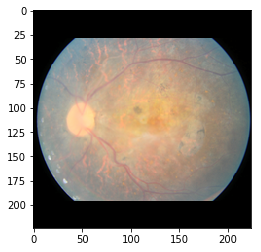

In [57]:
image_loc = './Retinal-Images/test_resize_224_new/27675_right.png'
plt.imshow(mpimg.imread(image_loc))

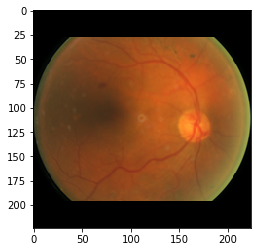

In [58]:
image_loc = './Retinal-Images/test_resize_224_new/39688_left.png'
plt.imshow(mpimg.imread(image_loc))

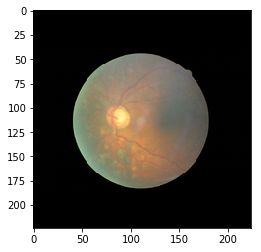

In [59]:
image_loc = './Retinal-Images/test_resize_224_new/11324_left.png'
plt.imshow(mpimg.imread(image_loc))

### True Positives

In [60]:
# Let us compare with true positive category 4
df_class_tp[df_class_tp.True_Label==4]

,Image,Actual,Pred,True_Label,DR_Positive_Proba
4800,5027_right,1,1,4,0.941966
4801,10362_left,1,1,4,0.999393
4802,28709_left,1,1,4,0.679782
4803,5313_left,1,1,4,0.937261
4804,24287_left,1,1,4,0.991018
4805,27719_left,1,1,4,0.996150
4806,12830_left,1,1,4,0.999450
4807,2546_right,1,1,4,0.997211
4808,17319_left,1,1,4,0.786883
4810,17055_right,1,1,4,0.997433


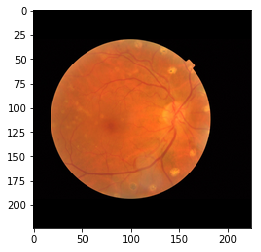

In [46]:
image_loc = './Retinal-Images/test_resize_224_new/34934_right.png'
plt.imshow(mpimg.imread(image_loc))

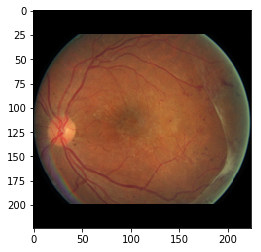

In [61]:
image_loc = './Retinal-Images/test_resize_224_new/2546_right.png'
plt.imshow(mpimg.imread(image_loc))


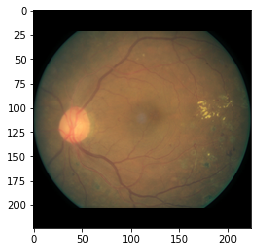

In [62]:
image_loc = './Retinal-Images/test_resize_224_new/12682_right.png'
plt.imshow(mpimg.imread(image_loc))


In [100]:
# Let us compare with true positive category 1
df_class_tp[df_class_tp.True_Label==1]

,Image,Actual,Pred,True_Label,DR_Positive_Proba
3301,35123_left,1,1,1,0.898918
3313,34652_right,1,1,1,0.613831
3316,16765_right,1,1,1,0.957002
3317,5977_left,1,1,1,0.783503
3332,38435_left,1,1,1,0.850744
3333,42559_left,1,1,1,0.841999
3334,41221_left,1,1,1,0.853788
3340,6383_right,1,1,1,0.538939
3342,9727_left,1,1,1,0.514746
3344,32857_left,1,1,1,0.733046


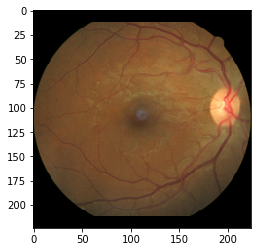

In [101]:
image_loc = './Retinal-Images/test_resize_224_new/16765_right.png'
plt.imshow(mpimg.imread(image_loc))

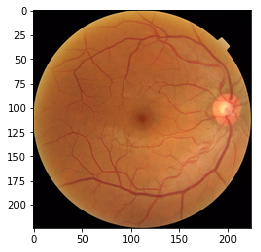

In [102]:
# Barely made category 1
image_loc = './Retinal-Images/test_resize_224_new/2486_right.png'
plt.imshow(mpimg.imread(image_loc))


# VGG19

## VGG19 7 layer fixed

In [107]:
model_vgg = load_model('./best_model_vgg19_l7.json',
                           './best_model_vgg19_finalEpoch_l7.h5')

In [108]:
image_class_proba_list = calc_proba_list(model_vgg)
df_pred_class = get_pred_df(image_class_proba_list)
df_class_tp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_tn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_fp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual!=df_pred_class.Pred)]
df_class_fn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual!=df_pred_class.Pred)]

In [109]:
df_pred_class.groupby(['Pred']).count()

,Image,Actual,True_Label,DR_Positive_Proba
Pred,,,,
0,3190,3190,3190,3190
1,1810,1810,1810,1810


TN: 2541,FP: 759, FN: 649, TP:1051


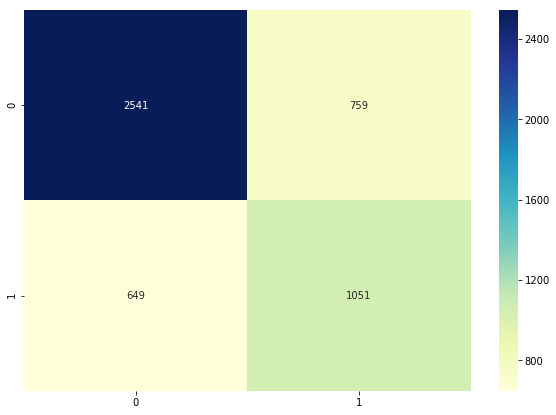

In [110]:
image_class_proba_arr = np.vstack(image_class_proba_list)
image_class_arr = np.argmax(image_class_proba_arr,axis=1)

cnf = confusion_matrix(test_labels, image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

#### The model is good, but did not beat VGG16 best model

In [113]:
# Best model returned instead of final epoch
model_vgg = load_model('./best_model_vgg19_l7.json',
                           './best_model_vgg19_l7.h5')

In [114]:
image_class_proba_list = calc_proba_list(model_vgg)
df_pred_class = get_pred_df(image_class_proba_list)
df_class_tp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_tn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_fp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual!=df_pred_class.Pred)]
df_class_fn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual!=df_pred_class.Pred)]

In [115]:
df_pred_class.groupby(['Pred']).count()

,Image,Actual,True_Label,DR_Positive_Proba
Pred,,,,
0,3282,3282,3282,3282
1,1718,1718,1718,1718


TN: 2635,FP: 665, FN: 647, TP:1053


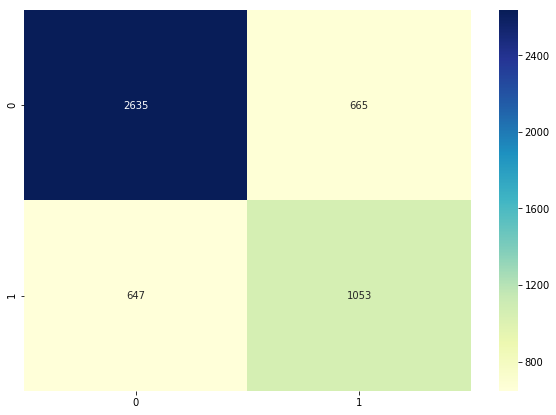

In [116]:
image_class_proba_arr = np.vstack(image_class_proba_list)
image_class_arr = np.argmax(image_class_proba_arr,axis=1)

cnf = confusion_matrix(test_labels, image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

#### This performed well, lowered the FPs but slight increase in FNs (617 was the best).

# VGG 16 with 512x512

In [39]:
# Best model returned instead of final epoch
model_vgg = load_model('/opt/DL/MODELS/best_model_TL_l7_512_bg.json',
                           '/opt/DL/MODELS/best_model_TL_l7_512_bg.h5')

In [37]:
image_class_proba_list = calc_proba_list(model_vgg,testList,scale=512)
df_pred_class = get_pred_df(image_class_proba_list)

df_class_tp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_tn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_fp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual!=df_pred_class.Pred)]
df_class_fn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual!=df_pred_class.Pred)]

TN: 3070,FP: 230, FN: 724, TP:976


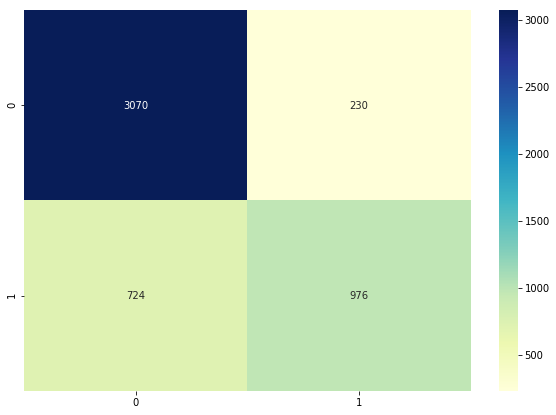

In [38]:
image_class_proba_arr = np.vstack(image_class_proba_list)
image_class_arr = np.argmax(image_class_proba_arr,axis=1)

cnf = confusion_matrix(test_labels, image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')